In [1]:
import json, os, cv2
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.cluster import KMeans
import matplotlib.colors as mcolors




## Load h5 files into group analysis dataframe

# intilize dataframe
df = pd.DataFrame()

# path to h5 files 
data_path = Path('~/Desktop/mike_bonsai/recordings/prelim_h5').expanduser()
h5s = []
h5s =  list((data_path).rglob('*.h5')) 


In [2]:
# dataframe of h5's
for h5 in h5s:
    a=pd.read_hdf(h5)
    df = df.append(a)
    

In [3]:
test=df[df['animal'].str.contains("G6CK3LT") & df['date'].str.contains("092721")]

In [4]:
test

,first_poke,second_poke,trail_timestamps,nose_x,nose_y,nose_likelihood,leftear_x,leftear_y,leftear_likelihood,rightear_x,...,bobstacle_x_cm,bobstacle_x_std,bobstacle_y_cm,bobstacle_y_std,wobstacle_x_cm,wobstacle_x_std,wobstacle_y_cm,wobstacle_y_std,speed,obstacle_cluster
2,39204.483801,39209.534489,"[39204.49632, 39204.512985, 39204.531161, 3920...","[64.13834381103516, 64.65543365478516, 64.5444...","[196.35372924804688, 196.20730590820312, 196.0...","[0.9972201585769653, 0.9961837530136108, 0.995...","[74.17947387695312, 74.08807373046875, 73.9409...","[205.64871215820312, 205.44029235839844, 205.4...","[0.9997563362121582, 0.9997261762619019, 0.999...","[83.50088500976562, 83.64659881591797, 83.6355...",...,3.411156,NaN,6.875518,2.196533,22.281383,0.342625,6.875518,2.196533,"[1.749697895304716, 0.3443952340051449, 1.6236...",2
4,39218.464486,39226.394918,"[39218.46926, 39218.483353, 39218.499955, 3921...","[53.822566986083984, 52.23098373413086, 52.021...","[196.81297302246094, 197.06642150878906, 197.0...","[0.9997934699058533, 0.9998007416725159, 0.999...","[84.49004364013672, 83.77938079833984, 83.3712...","[195.79945373535156, 195.58587646484375, 195.5...","[0.9999674558639526, 0.9999489188194275, 0.999...","[68.4342269897461, 68.32564544677734, 68.41108...",...,NaN,NaN,9.280102,0.010381,22.458857,0.024013,9.280102,0.010381,"[6.3683700035509965, 0.7103247114804931, 3.466...",2
5,39226.394918,39232.006886,"[39226.403596, 39226.419571, 39226.436211, 392...","[504.4343566894531, nan, nan, 502.648345947265...","[173.9981689453125, nan, nan, 172.794189453125...","[0.9903676509857178, 0.9872413873672485, 0.989...","[472.71466064453125, 472.5158996582031, 472.42...","[171.45704650878906, 171.59095764160156, 171.8...","[0.999783992767334, 0.9998521208763123, 0.9998...","[487.1942138671875, 486.548095703125, 485.9513...",...,NaN,NaN,11.787745,2.259291,14.157058,7.388797,11.787745,2.259291,"[nan, nan, nan, 0.04334580653256803, nan, nan,...",7
6,39232.006886,39236.410432,"[39232.021235, 39232.037913, 39232.055155, 392...","[63.681602478027344, 63.69581985473633, 63.409...","[199.45883178710938, 200.2185516357422, 200.65...","[0.9952743053436279, 0.9936250448226929, 0.993...","[76.71900177001953, 76.74441528320312, 76.6028...","[205.81947326660156, 206.42916870117188, 206.6...","[0.9998513460159302, 0.9998044967651367, 0.999...","[81.14069366455078, 80.4792251586914, 80.97708...",...,NaN,NaN,14.076417,0.073512,7.006245,0.042216,14.076417,0.073512,"[0.04807041605152948, 0.937844686112043, 1.419...",6
7,39236.410432,39241.116838,"[39236.42336, 39236.439616, 39236.456256, 3923...","[502.6612854003906, 501.9109802246094, 501.258...","[172.12413024902344, 173.19981384277344, 172.7...","[0.9940613508224487, 0.993005633354187, 0.9931...","[470.2296447753906, 469.47772216796875, 468.37...","[172.4290771484375, 172.8861541748047, 173.584...","[0.9998356103897095, 0.9998655319213867, 0.999...","[485.692138671875, 484.9634704589844, 484.6841...",...,NaN,NaN,12.064128,2.166136,10.104242,3.599540,12.064128,2.166136,"[2.6027150977849645, 2.212333078159064, 2.2820...",1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,39955.555123,39960.278041,"[39955.56718, 39955.583436, 39955.600089, 3995...","[nan, 504.5029602050781, 505.2521667480469, 50...","[nan, 176.49655151367188, 176.030029296875, 17...","[0.989058256149292, 0.9921600818634033, 0.9933...","[473.7869873046875, 473.9970703125, 473.534790...","[171.8802947998047, 171.41397094726562, 170.49...","[0.999790370464325, 0.9998224973678589, 0.9998...","[488.0886535644531, 488.3228454589844, 488.368...",...,NaN,NaN,6.200434,2.908876,14.127096,7.061571,6.200434,2.908876,"[nan, 2.5369473785235854, 0.5486213292292746, ...",0
152,39960.278041,39964.251430,"[39960.285465, 39960.301632, 39960.319462, 399...","[66.08959197998047, 65.97652435302734, 65.9309...","[192.95530700683594, 194.04039001464844, 193.8...","[0.9964771866798401, 0.9958763122558594, 0.995...",

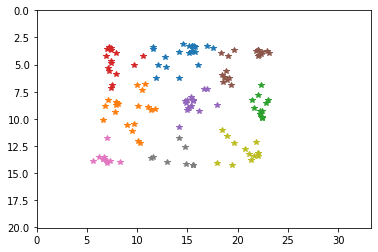

In [4]:
# k means of pillar postion 
kmeans_input = np.stack([test['wobstacle_x_cm'].map(np.nanmean), test['wobstacle_y_cm'].map(np.nanmean)])
kmeans_mask = np.any(np.isnan(kmeans_input), axis=0)
kmeans_input = kmeans_input[:,~kmeans_mask]

# plot cluster postions
cluster_label = test['obstacle_cluster'].tolist()

plt.figure()
for i in range(len(test['obstacle_cluster'])):
    obstacles = kmeans_input[:,i]
    plt.plot(obstacles[0], obstacles[1], '*',color=list(mcolors.TABLEAU_COLORS)[cluster_label[i]])
    plt.ylim([20.03, 0]); plt.xlim([0, 33.30])

In [6]:
## create gt_label
# Cluster condition
cluster_con = [
    (test['obstacle_cluster'] == 3), (test['obstacle_cluster'] == 0), (test['obstacle_cluster'] == 5),
    (test['obstacle_cluster'] == 1), (test['obstacle_cluster'] == 4), (test['obstacle_cluster'] == 2),
    (test['obstacle_cluster'] == 6), (test['obstacle_cluster'] == 7), (test['obstacle_cluster'] == 8)
    ]
# list of gt_labels
gt_values = [
    'TL','TM','TR',
    'ML','MM','MR',
    'RL','RM','RR'
    ]
# gt_label
test['gt_label'] = np.select(cluster_con, gt_values)

In [7]:
## Given a cluster num get median obstacle position
# Create column for gt_label,gt_x = median of x postion given ground truth label,gt_y = median of x postion given ground truth label

## create gt_label
# Cluster condition
cluster_con = [
    (test['obstacle_cluster'] == 3), (test['obstacle_cluster'] == 0), (test['obstacle_cluster'] == 5),
    (test['obstacle_cluster'] == 1), (test['obstacle_cluster'] == 4), (test['obstacle_cluster'] == 2),
    (test['obstacle_cluster'] == 6), (test['obstacle_cluster'] == 7), (test['obstacle_cluster'] == 8)
    ]
# list of gt_labels
gt_valuesnum = [
    0,1,2,
    3,4,5,
    6,7,8
]
# gt_label
test['gt_label#'] = np.select(cluster_con, gt_valuesnum)

## get ground truth obstcle  location
#Get median obstacle x y values  by obstacle location

#Tl 
TL_x = test.loc[test['gt_label'] == 'TL']
TL_x = np.median(TL_x['wobstacle_x_cm'])

TL_y = test.loc[test['gt_label'] == 'TL']
TL_y = np.median(TL_y['wobstacle_y_cm'])
#TM
TM_x = test.loc[test['gt_label'] == 'TM']
TM_x = np.median(TM_x['wobstacle_x_cm'])

TM_y = test.loc[test['gt_label'] == 'TM']
TM_y = np.median(TM_y['wobstacle_y_cm'])
#TR
TR_x = test.loc[test['gt_label'] == 'TR']
TR_x = np.median(TR_x['wobstacle_x_cm'])

TR_y = test.loc[test['gt_label'] == 'TR']
TR_y = np.median(TR_y['wobstacle_y_cm'])





#ML
ML_x = test.loc[test['gt_label'] == 'ML']
ML_x = np.median(ML_x['wobstacle_x_cm'])

ML_y = test.loc[test['gt_label'] == 'ML']
ML_y = np.median(ML_y['wobstacle_y_cm'])
#MM
MM_x = test.loc[test['gt_label'] == 'MM']
MM_x = np.median(MM_x['wobstacle_x_cm'])

MM_y = test.loc[test['gt_label'] == 'MM']
MM_y = np.median(MM_y['wobstacle_y_cm'])
#MR
MR_x = test.loc[test['gt_label'] == 'MR']
MR_x = np.median(MR_x['wobstacle_x_cm'])

MR_y = test.loc[test['gt_label'] == 'MR']
MR_y = np.median(MR_y['wobstacle_y_cm'])


#Bl 
RL_x = test.loc[test['gt_label'] == 'RL']
RL_x = np.median(RL_x['wobstacle_x_cm'])

RL_y = test.loc[test['gt_label'] == 'RL']
RL_y = np.median(RL_y['wobstacle_y_cm'])
#TM
RM_x = test.loc[test['gt_label'] == 'RM']
RM_x = np.median(RM_x['wobstacle_x_cm'])

RM_y = test.loc[test['gt_label'] == 'RM']
RM_y = np.median(RM_y['wobstacle_y_cm'])
#TR
RR_x = test.loc[test['gt_label'] == 'RR']
RR_x = np.median(RR_x['wobstacle_x_cm'])

RR_y = test.loc[test['gt_label'] == 'RR']
RR_y = np.median(RR_y['wobstacle_y_cm'])

In [8]:
# Create gt_x column 

gt_x_con = [
    (test['gt_label'] == 'TL'), (test['gt_label'] == 'TM'), (test['gt_label'] == 'TR'),
    (test['gt_label'] == 'ML'), (test['gt_label'] == 'MM'), (test['gt_label'] == 'MR'),
    (test['gt_label'] == 'RL'), (test['gt_label'] == 'RM'), (test['gt_label'] == 'RR')
    ]


gt_xvalues_lable = [
    TL_x,TM_x,TR_x,
    ML_x,MM_x,MR_x,
    RL_x,RM_x,RR_x
    ]


test['gt_xvalues'] = np.select(gt_x_con, gt_xvalues_lable)

In [9]:
# Create gt_y column 

gt_y_con = [
    (test['gt_label'] == 'TL'), (test['gt_label'] == 'TM'), (test['gt_label'] == 'TR'),
    (test['gt_label'] == 'ML'), (test['gt_label'] == 'MM'), (test['gt_label'] == 'MR'),
    (test['gt_label'] == 'RL'), (test['gt_label'] == 'RM'), (test['gt_label'] == 'RR')
    ]


gt_yvalues_lable = [
    TL_y,TM_y,TR_y,
    ML_y,MM_y,MR_y,
    RL_y,RM_y,RR_y
    ]


test['gt_yvalues'] = np.select(gt_y_con, gt_yvalues_lable)

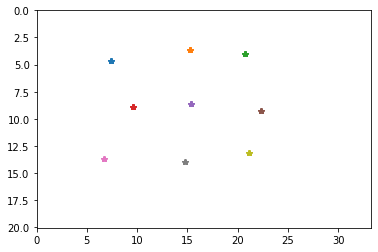

In [10]:
# plot gt postions
gt_label = test['gt_label#'].tolist()
#create obstacle_xypos array 
obstacle_xpos = np.array(test.loc[:,'gt_xvalues'])
obstacle_ypos = np.array(test.loc[:,'gt_yvalues'])
obstacle_xypos_ar = np.stack((obstacle_xpos, obstacle_ypos))
plt.figure()
for i in range(len(test['gt_label#'])):
    obstacle_xypos = obstacle_xypos_ar[:,i] 
    plt.plot(obstacle_xypos[0], obstacle_xypos[1], '*', color=list(mcolors.TABLEAU_COLORS)[gt_label[i]])
    plt.ylim([20.03, 0]); plt.xlim([0, 33.30])

In [11]:
# Dic of gt location with labels
dd = test.drop_duplicates(subset=['gt_xvalues','gt_yvalues','gt_label'])
gt_lb_list = dd['gt_label'].tolist()
xy_list = list(zip(dd['gt_xvalues'].tolist(), dd['gt_yvalues'].tolist()))
gt_dict = dict(zip(gt_lb_list,xy_list))


In [12]:
gt_dict

{'MR': (22.28138312829813, 9.249234359517668),
 'RM': (14.797510055949397, 13.987894457005025),
 'RL': (6.71280960420305, 13.683454941135901),
 'ML': (9.585954622658765, 8.879183775501776),
 'MM': (15.347617775011052, 8.658760750703212),
 'TM': (15.286871693900007, 3.627682445349567),
 'TL': (7.393186265817571, 4.620800416234327),
 'RR': (21.17443544521096, 13.134878098224073),
 'TR': (20.74954858478275, 4.045610514763407)}

In [13]:
test2=df[df['animal'].str.contains("G6CK3RT") & df['date'].str.contains("092721")]

In [14]:
gt_dict.items()

dict_items([('MR', (22.28138312829813, 9.249234359517668)), ('RM', (14.797510055949397, 13.987894457005025)), ('RL', (6.71280960420305, 13.683454941135901)), ('ML', (9.585954622658765, 8.879183775501776)), ('MM', (15.347617775011052, 8.658760750703212)), ('TM', (15.286871693900007, 3.627682445349567)), ('TL', (7.393186265817571, 4.620800416234327)), ('RR', (21.17443544521096, 13.134878098224073)), ('TR', (20.74954858478275, 4.045610514763407))])

In [15]:
test2[['wobstacle_x_cm','wobstacle_y_cm']]

,wobstacle_x_cm,wobstacle_y_cm
2,7.071123,4.184478
4,22.328458,3.742016
5,13.152247,9.738008
6,6.802451,13.854271
7,11.518973,13.977612
...,...,...
142,22.262802,14.170860
143,19.076431,14.240540
144,14.396617,14.359703
145,11.044918,14.371118


In [17]:
for name, xy in gt_dict.items():
    print(xy[0])

22.28138312829813
14.797510055949397
6.71280960420305
9.585954622658765
15.347617775011052
15.286871693900007
7.393186265817571
21.17443544521096
20.74954858478275


In [18]:
test2=test2[~pd.isnull(test2['wobstacle_x_cm'])][~pd.isnull(test2['wobstacle_y_cm'])]

In [19]:
gt_dict

{'MR': (22.28138312829813, 9.249234359517668),
 'RM': (14.797510055949397, 13.987894457005025),
 'RL': (6.71280960420305, 13.683454941135901),
 'ML': (9.585954622658765, 8.879183775501776),
 'MM': (15.347617775011052, 8.658760750703212),
 'TM': (15.286871693900007, 3.627682445349567),
 'TL': (7.393186265817571, 4.620800416234327),
 'RR': (21.17443544521096, 13.134878098224073),
 'TR': (20.74954858478275, 4.045610514763407)}

In [21]:
xy_fits = []
for ind, row in test2.iterrows():
    xyfit = []
    for name, xy in gt_dict.items():
    xyfit.append(np.sqrt(np.abs(xy[0]-row['wobstacle_x_cm'])**2 + np.abs(xy[1]-row['wobstacle_y_cm']))**2)
    xy_fits.append(np.argmin(xyfit))            
test2['xy_fit'] = xy_fits

for ind, row in test2.iterrows():
    fit = np.zeros(len(gt_dict))
    i = 0
    for name, xy in gt_dict.items():
        fit[i] = (np.sqrt(np.abs(xy[0]-row['wobstacle_x_cm'])**2 + np.abs(xy[1]-row['wobstacle_y_cm']))**2)
        i += 1
    test2.at[ind, 'distance_to_fit'] = np.min(fit) 
    test2.at[ind, 'xyfit'] = np.argmin(fit)

for ind, row in test2.iterrows():
    test2.at[ind, 'object_position_name'] = list(gt_dict.keys())[int(row['xyfit'])]

In [24]:
test2['object_position_name']

2      TL
4      TR
5      MM
6      RL
7      ML
       ..
142    RR
143    RR
144    RM
145    ML
147    ML
Name: object_position_name, Length: 133, dtype: object

(array([47., 28., 20.,  8., 11.,  5.,  0.,  6.,  6.,  2.]),
 array([3.09010354e-03, 1.05100472e+00, 2.09891935e+00, 3.14683397e+00,
        4.19474859e+00, 5.24266321e+00, 6.29057783e+00, 7.33849245e+00,
        8.38640707e+00, 9.43432170e+00, 1.04822363e+01]),
 <BarContainer object of 10 artists>)

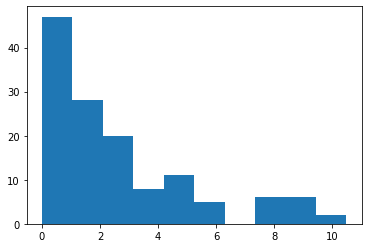

In [217]:
plt.hist(test2['distance_to_fit'])

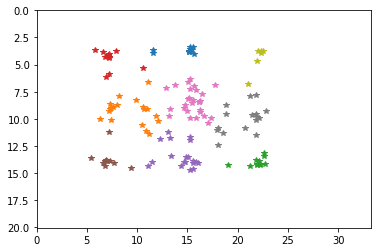

In [156]:
# k means of pillar postion 
kmeans_input = np.stack([test2['wobstacle_x_cm'].map(np.nanmean), test2['wobstacle_y_cm'].map(np.nanmean)])
kmeans_mask = np.any(np.isnan(kmeans_input), axis=0)
kmeans_input = kmeans_input[:,~kmeans_mask]

# plot cluster postions
cluster_label = test2['obstacle_cluster'].tolist()

plt.figure()
for i in range(len(test2['obstacle_cluster'])):
    obstacles = kmeans_input[:,i]
    plt.plot(obstacles[0], obstacles[1], '*', color=list(mcolors.TABLEAU_COLORS)[cluster_label[i]])
    plt.ylim([20.03, 0]); plt.xlim([0, 33.30])

In [138]:
xyfit.shape

(133,)

In [135]:
pee=[]
for ind, row in test2.iterrows():
    for name, xy in gt_dict.items():
        xfit = xy[0] - row['wobstacle_x_cm']
        pee.append(xfit)
                 
        

In [136]:
len(pee)

1197

In [134]:
len(xfit)

TypeError: object of type 'float' has no len()

In [130]:
len(test2['wobstacle_x_cm'].tolist())

133

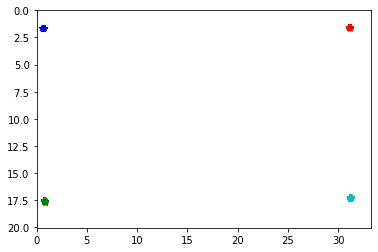

In [214]:
# plot gt postions
gt_label = test['gt_label#'].tolist()
#create obstacle_xypos array 
arenatl_xpos = np.array(test.loc[:,'arenaTL_x_cm'])
arenatl_ypos = np.array(test.loc[:,'arenaTL_y_cm'])
arenatl_xypos_ar = np.stack((arenatl_xpos, arenatl_ypos))

arenatr_xpos = np.array(test.loc[:,'arenaTR_x_cm'])
arenatr_ypos = np.array(test.loc[:,'arenaTR_y_cm'])
arenatr_xypos_ar = np.stack((arenatr_xpos, arenatr_ypos))

arenabl_xpos = np.array(test.loc[:,'arenaBL_x_cm'])
arenabl_ypos = np.array(test.loc[:,'arenaBL_y_cm'])
arenabl_xypos_ar = np.stack((arenabl_xpos, arenabl_ypos))

arenabr_xpos = np.array(test.loc[:,'arenaBR_x_cm'])
arenabr_ypos = np.array(test.loc[:,'arenaBR_y_cm'])
arenabr_xypos_ar = np.stack((arenabr_xpos, arenabr_ypos))




plt.figure()
for i in range(len(test['gt_label#'])):
    arenatl_xypos = arenatl_xypos_ar[:,i] 
    arenatr_xypos = arenatr_xypos_ar[:,i] 
    arenabl_xypos = arenabl_xypos_ar[:,i] 
    arenabr_xypos = arenabr_xypos_ar[:,i] 
    plt.plot( arenatl_xypos[0],  arenatl_xypos[1], '*', color='b')
    plt.plot( arenatr_xypos[0],  arenatr_xypos[1], '*', color='r')
    plt.plot( arenabl_xypos[0],  arenabl_xypos[1], '*', color='g')
    plt.plot( arenabr_xypos[0],  arenabr_xypos[1], '*', color='c')
        
    plt.ylim([20.03, 0]); plt.xlim([0, 33.30])